# Image Recognition with Convolutional Neural Networks

This exercise challenges you to build an image recognition model using a convolutional neural network. You'll select an image dataset, then train a model for image classification, object detection, or image segmentation using convolutional neural networks.

**Tasks:**

1. **Dataset Selection:** Choose a dataset. Consider dataset size, complexity, and availability. Only public datasets are acceptable. Briefly describe your dataset.
2. **Data Preparation:** Prepare the data: resize images, augment data, and split into training, validation, and test sets.
3. **Model Selection:** Choose a neural network architecture. Justify your choice based on the dataset and task.
4. **Training:** Train your model on the training data, monitoring performance on the validation set.
5. **Evaluation:** Evaluate the model's performance on the test set using appropriate metrics (e.g., accuracy, precision, recall, F1-score, mAP, IoU).
6. **Results and Discussion:** Present results, analyze performance, and discuss limitations or areas for improvement.

**Dataset Examples:**

* **Classification:** CIFAR-10/100, MNIST
* **Object Detection:** Pascal VOC/COCO
* **Segmentation:** Cityscapes

**Deliverables:**

* Jupyter Notebook with code for data preparation, model training, and evaluation. The outputs of the different code cells should be visible. At the end of the notebook add a brief report summarizing your approach, results, and discussion.

## 1. Dataset description, download and exploration

Este dataset de kaggle tiene una 200k imágenes de personas con y sin pelo. El objetivo es hacer una red que prediga si la persona de la foto esta calva o no. 

In [1]:
import os
from PIL import Image # Para abrir y examinar imágenes
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter # Para contar ocurrencias (ej. tamaños de imagen)
import random # Para seleccionar muestras aleatorias
import pandas as pd # Para mostrar tablas de resumen

In [2]:
import kagglehub

# Download latest version
# path = kagglehub.dataset_download("ashishjangra27/bald-classification-200k-images-celeba")

# print("Path to dataset files:", path)

/Users/jorgemolto/Documents/PARA/01-Projects/EDEM/MIA/02. Modelos de IA/04_DL/02 - CNN/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# --- Configuración ---
data_dir = 'Dataset' # Ruta a tu carpeta principal
splits = ['Train', 'Validation', 'Test'] # Las subcarpetas que esperamos encontrar

print(f"Iniciando EDA para el dataset en: {data_dir}")
print("-" * 30)

# --- 1. Descubrir Clases y Contar Imágenes por Split ---
class_info = {}
all_classes = set() # Para guardar todos los nombres de clase únicos

print("1. Contando imágenes por clase y por split...")

for split in splits:
    split_path = os.path.join(data_dir, split)
    if not os.path.isdir(split_path):
        print(f"ADVERTENCIA: No se encontró el directorio '{split_path}'. Saltando este split.")
        continue

    # Las clases son las subcarpetas dentro de Train, Validation, Test
    try:
        classes_in_split = sorted([d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))])
    except FileNotFoundError:
        print(f"ERROR: No se pudo acceder a '{split_path}'. Verifica la ruta.")
        continue

    if not classes_in_split:
         print(f"ADVERTENCIA: No se encontraron carpetas de clases en '{split_path}'.")
         continue

    all_classes.update(classes_in_split) # Agrega las clases encontradas a nuestro conjunto global
    class_counts = {}
    print(f"\n--- Split: {split} ---")
    for class_name in classes_in_split:
        class_path = os.path.join(split_path, class_name)
        try:
            # Contar solo archivos (ignorar subdirectorios si los hubiera)
            num_images = len([f for f in os.listdir(class_path)
                              if os.path.isfile(os.path.join(class_path, f))])
            class_counts[class_name] = num_images
            # print(f"  Clase '{class_name}': {num_images} imágenes") # Descomentar para detalle
        except Exception as e:
            print(f"  ERROR al procesar '{class_path}': {e}")
            class_counts[class_name] = 0 # Marcar como 0 si hay error

    class_info[split] = class_counts

# Ordenar la lista completa de clases alfabéticamente
sorted_classes = sorted(list(all_classes))
num_classes = len(sorted_classes)

print("-" * 30)
print(f"\nTotal de clases únicas encontradas: {num_classes}")
print(f"Nombres de las clases: {sorted_classes}")

# Crear un DataFrame de pandas para una mejor visualización de los conteos
try:
    df_counts = pd.DataFrame(class_info).fillna(0).astype(int)
    # Asegurar que las filas estén ordenadas por nombre de clase
    df_counts = df_counts.reindex(sorted_classes, fill_value=0)
    df_counts['Total_Clase'] = df_counts.sum(axis=1)
    df_counts.loc['Total_Split'] = df_counts.sum(axis=0) # Añadir fila de totales por split
    print("\nResumen de conteo de imágenes:")
    print(df_counts)
except Exception as e:
    print(f"\nNo se pudo crear el resumen en tabla (quizás no se encontraron datos): {e}")
    print("Conteos crudos:", class_info)

Iniciando EDA para el dataset en: Dataset
------------------------------
1. Contando imágenes por clase y por split...

--- Split: Train ---

--- Split: Validation ---

--- Split: Test ---
------------------------------

Total de clases únicas encontradas: 2
Nombres de las clases: ['Bald', 'NotBald']

Resumen de conteo de imágenes:
              Train  Validation   Test  Total_Clase
Bald           3656         470    421         4547
NotBald      156344       22129  19579       198052
Total_Split  160000       22599  20000       202599


Hay 2 clases, Calvo y No Calvo. Se encuentra muy desbalanceada a favor de los No Calvos.

In [4]:
# --- 3. Analizar Dimensiones y Modos de Imagen  ---
print("\n3. Analizando dimensiones y modos de color (usando una muestra)...")
image_files_sample = []
dimensions = []
modes = Counter()
sample_size = 100 # Número total de imágenes a muestrear de todo el dataset
files_to_sample_from = []

# Recolectar rutas de archivos de todos los splits y clases disponibles
for split, classes in class_info.items():
    split_path = os.path.join(data_dir, split)
    for class_name in classes:
        class_path = os.path.join(split_path, class_name)
        try:
            files = [os.path.join(class_path, f) for f in os.listdir(class_path)
                     if os.path.isfile(os.path.join(class_path, f))]
            files_to_sample_from.extend(files)
        except Exception as e:
            print(f"  Advertencia: No se pudo listar archivos en {class_path}: {e}")

# Tomar una muestra aleatoria si hay suficientes archivos
if len(files_to_sample_from) > 0:
    actual_sample_size = min(sample_size, len(files_to_sample_from))
    image_files_sample = random.sample(files_to_sample_from, actual_sample_size)
    print(f"Se analizará una muestra de {len(image_files_sample)} imágenes.")

    for img_path in image_files_sample:
        try:
            with Image.open(img_path) as img:
                dimensions.append(img.size) # (width, height)
                modes[img.mode] += 1
        except Exception as e:
            print(f"ADVERTENCIA: No se pudo abrir o leer '{img_path}': {e}")

    if dimensions:
        # Resumen de Dimensiones
        dim_counts = Counter(dimensions)
        print(f"\nDimensiones encontradas en la muestra (ancho x alto):")
        print(f"  Número de dimensiones únicas: {len(dim_counts)}")
        print("  Dimensiones más comunes:")
        for dim, count in dim_counts.most_common(5):
            print(f"    - {dim}: {count} veces")

        # Estadísticas básicas
        widths = [d[0] for d in dimensions]
        heights = [d[1] for d in dimensions]
        print(f"  Anchos: Mín={min(widths)}, Máx={max(widths)}, Prom={np.mean(widths):.0f}")
        print(f"  Alturas: Mín={min(heights)}, Máx={max(heights)}, Prom={np.mean(heights):.0f}")


3. Analizando dimensiones y modos de color (usando una muestra)...
Se analizará una muestra de 100 imágenes.

Dimensiones encontradas en la muestra (ancho x alto):
  Número de dimensiones únicas: 1
  Dimensiones más comunes:
    - (178, 218): 100 veces
  Anchos: Mín=178, Máx=178, Prom=178
  Alturas: Mín=218, Máx=218, Prom=218



4. Visualizando algunas imágenes de muestra por clase...


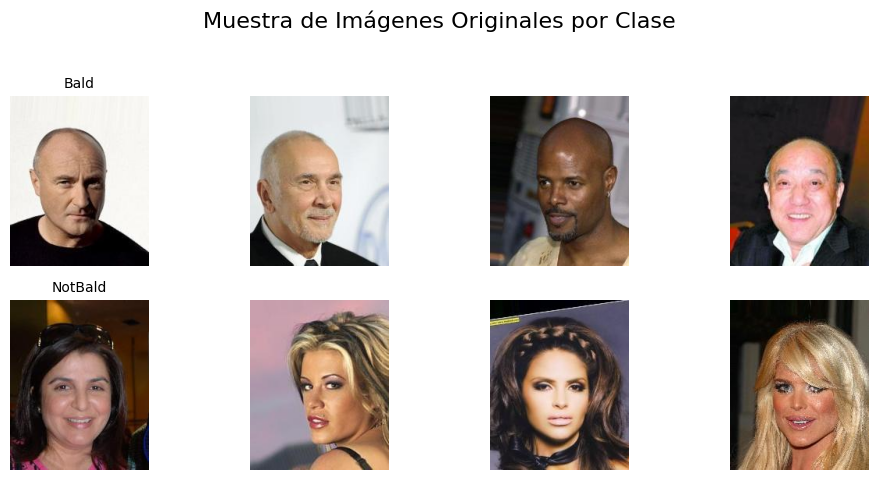

In [27]:
# --- 4. Visualizar Imágenes de Muestra por Clase ---
print("\n4. Visualizando algunas imágenes de muestra por clase...")

def display_sample_images(data_dir, classes, n_samples_per_class=4):
    if not classes:
        print("No hay clases definidas para mostrar imágenes.")
        return

    plt.figure(figsize=(n_samples_per_class * 2.5, len(classes) * 2.5)) # Ajustar tamaño
    plot_idx = 1
    max_plots = len(classes) * n_samples_per_class

    for i, class_name in enumerate(classes):
        # Intentar obtener imágenes de la carpeta 'Train' primero
        class_path = os.path.join(data_dir, 'Train', class_name)
        # Fallback a Validation o Test si no existe en Train o está vacío
        if not os.path.isdir(class_path):
             for split_fallback in ['Validation', 'Test']:
                 class_path_fallback = os.path.join(data_dir, split_fallback, class_name)
                 if os.path.isdir(class_path_fallback):
                     class_path = class_path_fallback
                     break

        if not os.path.isdir(class_path):
             print(f"Advertencia: No se encontró directorio para la clase '{class_name}' en ningún split.")
             # Rellenar espacios en el subplot para mantener la cuadrícula
             for _ in range(n_samples_per_class):
                 if plot_idx <= max_plots:
                     ax = plt.subplot(len(classes), n_samples_per_class, plot_idx)
                     ax.text(0.5, 0.5, f'{class_name}\n(No dir)', ha='center', va='center', fontsize=8)
                     ax.axis('off')
                     plot_idx += 1
             continue # Pasar a la siguiente clase

        try:
            image_files = [os.path.join(class_path, f) for f in os.listdir(class_path)
                           if os.path.isfile(os.path.join(class_path, f))]
            if not image_files:
                print(f"Advertencia: No se encontraron imágenes en '{class_path}'.")
                # Rellenar espacios
                for _ in range(n_samples_per_class):
                     if plot_idx <= max_plots:
                         ax = plt.subplot(len(classes), n_samples_per_class, plot_idx)
                         ax.text(0.5, 0.5, f'{class_name}\n(Empty)', ha='center', va='center', fontsize=8)
                         ax.axis('off')
                         plot_idx += 1
                continue

            # Seleccionar muestras aleatorias
            sample_files = random.sample(image_files, min(n_samples_per_class, len(image_files)))

            for j, img_path in enumerate(sample_files):
                if plot_idx > max_plots: break # Evitar error si hay más imágenes que plots

                ax = plt.subplot(len(classes), n_samples_per_class, plot_idx)
                try:
                    img = Image.open(img_path)
                    # No aplicamos transformaciones aquí, solo mostramos original
                    plt.imshow(img)
                    plt.axis('off')
                    if j == 0: 
                        ax.set_title(class_name, fontsize=10)
                except Exception as e:
                    print(f"Error al mostrar {img_path}: {e}")
                    ax.text(0.5, 0.5, 'Error\nLoad', ha='center', va='center', color='red', fontsize=8)
                    ax.axis('off')
                plot_idx += 1

            # Rellenar si se mostraron menos de n_samples_per_class
            remaining_plots = n_samples_per_class - len(sample_files)
            for _ in range(remaining_plots):
                if plot_idx <= max_plots:
                    ax = plt.subplot(len(classes), n_samples_per_class, plot_idx)
                    ax.axis('off') # Espacio vacío
                    plot_idx += 1


        except Exception as e:
            print(f"Error procesando la clase '{class_name}': {e}")
            # Rellenar los plots restantes para esta clase si falla
            for _ in range(n_samples_per_class):
                 if plot_idx <= max_plots:
                     ax = plt.subplot(len(classes), n_samples_per_class, plot_idx)
                     ax.text(0.5, 0.5, f'{class_name}\n(Error)', ha='center', va='center', color='red', fontsize=8)
                     ax.axis('off')
                     plot_idx += 1

    plt.suptitle('Muestra de Imágenes Originales por Clase', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar para dejar espacio al supertítulo
    plt.show()

# Llamar a la función de visualización
if sorted_classes:
    display_sample_images(data_dir, sorted_classes, n_samples_per_class=4) # Mostrar 4 imágenes por clase
else:
    print("No se encontraron clases para visualizar imágenes.")

## 2. Data preparation and augmentation

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms # Necesitarás transforms para aplicar
from PIL import Image # Para cargar imágenes
import torchvision # Para visualización opcional

In [6]:
# --- 1. Definir la Clase Dataset Personalizada ---

class ImageSplitDataset(Dataset):
    """
    Dataset personalizado que carga imágenes desde una estructura de carpetas
    donde cada subcarpeta representa una clase, dentro de un directorio de split específico
    (ej. 'Dataset/Train', 'Dataset/Validation', 'Dataset/Test').
    """
    def __init__(self, split_dir, transform=None):
        """
        Args:
            split_dir (string): Ruta al directorio del split específico
                                (ej. 'Dataset/Train' o 'Dataset/Validation').
                                Se espera que dentro de este directorio haya subcarpetas,
                                cada una representando una clase y conteniendo imágenes.
            transform (callable, optional): Transformaciones opcionales a aplicar
                                            a cada muestra de imagen.
        """
        self.split_dir = split_dir
        self.transform = transform

        # Obtener los nombres de las clases (nombres de las subcarpetas)
        # y asegurarse de que estén ordenados para consistencia
        self.class_names = os.listdir(split_dir)
        self.image_paths = []
        self.labels = [] # Almacenaremos las etiquetas numéricas (índices)

        self.class_to_idx = {class_name: i for i, class_name in enumerate(self.class_names)}
        self.idx_to_class = {i: class_name for class_name, i in self.class_to_idx.items()}

        # Recorrer cada carpeta de clase y listar las imágenes
        print(f"Cargando datos desde: {self.split_dir}")
        for class_name in self.class_names:
            class_dir = os.path.join(self.split_dir, class_name)
            class_index = self.class_to_idx[class_name]
            try:
                for image_name in os.listdir(class_dir):
                    image_path = os.path.join(class_dir, image_name)
                    # Comprobar si es un archivo (ignorar posibles subdirectorios accidentales)
                    if os.path.isfile(image_path):
                        # Podrías añadir aquí una comprobación de extensión si quieres (ej. .jpg, .png)
                        self.image_paths.append(image_path)
                        self.labels.append(class_index) # Guardar el índice numérico
            except Exception as e:
                 print(f"  Advertencia: No se pudo procesar completamente la carpeta '{class_dir}': {e}")

    def __len__(self):
        """Devuelve el número total de imágenes en este split."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Obtiene una muestra (imagen y etiqueta) del dataset.

        Args:
            idx (int): Índice de la muestra a obtener.

        Returns:
            tuple: (image, label) donde image es la imagen transformada
                   y label es el índice numérico de la clase.
        """
        # Obtener la ruta de la imagen y su etiqueta numérica
        image_path = self.image_paths[idx]
        label = self.labels[idx] # Etiqueta numérica (índice)
        image = Image.open(image_path).convert('RGB')

        # Aplicar las transformaciones si existen
        if self.transform:
            image = self.transform(image)

        label_name = self.idx_to_class[label]
        return image, label, label_name

In [7]:
# Definimos transformadores para el conjunto de entrenamiento, validación y prueba
data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [8]:
data_dir = 'Dataset'
# Diccionario para guardar los datasets (buena práctica)
image_datasets = {}

train_split_dir = os.path.join(data_dir, 'Train')
image_datasets['Train'] = ImageSplitDataset(split_dir=train_split_dir,
                                                transform=data_transforms['Train'])
print(f"Dataset 'Train' creado desde: {train_split_dir}")

val_split_dir = os.path.join(data_dir, 'Validation')
image_datasets['Validation'] = ImageSplitDataset(split_dir=val_split_dir,
                                                transform=data_transforms['Validation'])
print(f"Dataset 'Validation' creado desde: {val_split_dir}")

test_split_dir = os.path.join(data_dir, 'Test')
image_datasets['Test'] = ImageSplitDataset(split_dir=test_split_dir,
                                                transform=data_transforms['Test'])
print(f"Dataset 'Test' creado desde: {test_split_dir}")



Cargando datos desde: Dataset/Train
Dataset 'Train' creado desde: Dataset/Train
Cargando datos desde: Dataset/Validation
Dataset 'Validation' creado desde: Dataset/Validation
Cargando datos desde: Dataset/Test
Dataset 'Test' creado desde: Dataset/Test


In [9]:
# Check dataset sizes
len(image_datasets['Train']), len(image_datasets['Validation']), len(image_datasets['Test'])

(160000, 22599, 20000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4831376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8956583..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


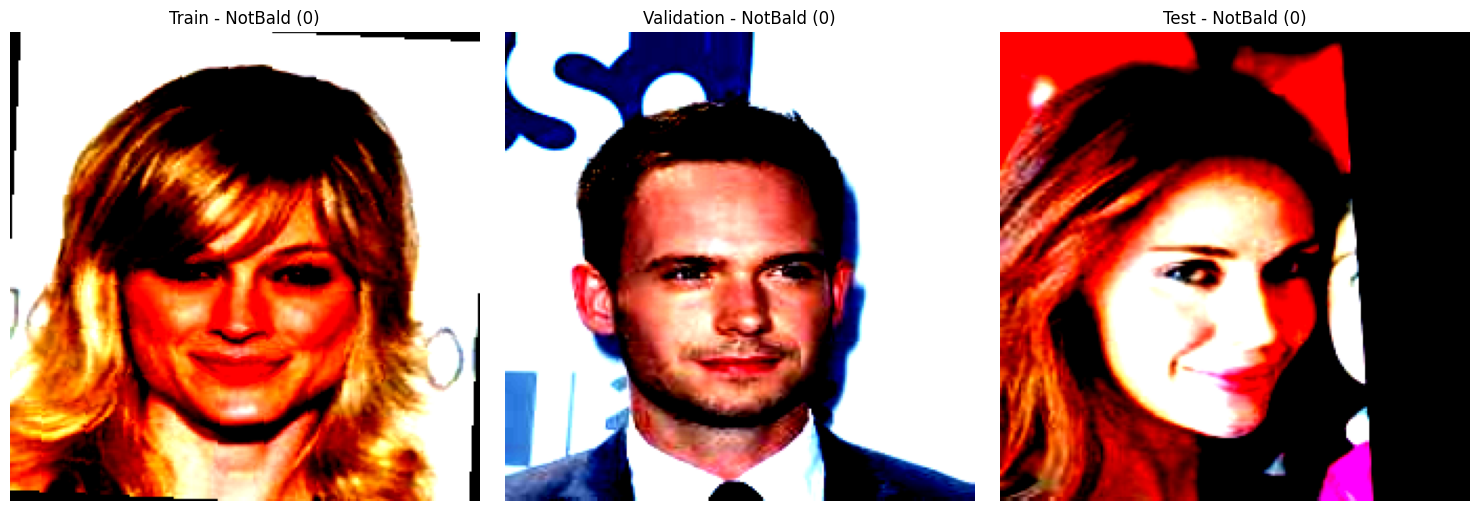

In [10]:
import matplotlib.pyplot as plt
import torch # Necesario para .permute()

# --- Índice a visualizar ---
image_index = 42 

# --- Crear la figura y los ejes ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # 1 fila, 3 columnas

# --- Obtener y mostrar imagen de Entrenamiento ---
img_train, label_idx_train, label_name_train = image_datasets['Train'][image_index]
axes[0].imshow(img_train.permute(1, 2, 0)) # Permutar C,H,W -> H,W,C
axes[0].set_title(f"Train - {label_name_train} ({label_idx_train})")
axes[0].axis('off')

# --- Obtener y mostrar imagen de Validación ---
img_val, label_idx_val, label_name_val = image_datasets['Validation'][image_index]
axes[1].imshow(img_val.permute(1, 2, 0))
axes[1].set_title(f"Validation - {label_name_val} ({label_idx_val})")
axes[1].axis('off')

# --- Obtener y mostrar imagen de Test ---
img_test, label_idx_test, label_name_test = image_datasets['Test'][image_index]
axes[2].imshow(img_test.permute(1, 2, 0))
axes[2].set_title(f"Test - {label_name_test} ({label_idx_test})")
axes[2].axis('off')

# --- Ajustar diseño y mostrar ---
plt.tight_layout()
plt.show()


In [11]:
batch_size = 32 # Define cuántas imágenes irán en cada lote

# --- DataLoader para Entrenamiento ---
train_loader = DataLoader(
    dataset=image_datasets['Train'], # El Dataset de donde sacar los datos
    batch_size=batch_size,           # Tamaño del lote
    shuffle=True         
)

# --- DataLoader para Validación ---
val_loader = DataLoader(
    dataset=image_datasets['Validation'], # El Dataset de validación
    batch_size=batch_size,              # Mismo tamaño de lote (o puede ser mayor si tienes memoria)
    shuffle=False
)

# --- DataLoader para Test ---
test_loader = DataLoader(
    dataset=image_datasets['Test'],     # El Dataset de test
    batch_size=batch_size,              # Mismo tamaño de lote
    shuffle=False
)

print("DataLoaders creados:")
print(f" - train_loader: {len(train_loader)} lotes de tamaño aprox. {batch_size}")
# len(train_loader) te da el número de lotes: ceil(len(train_dataset) / batch_size)
print(f" - val_loader: {len(val_loader)} lotes de tamaño aprox. {batch_size}")
print(f" - test_loader: {len(test_loader)} lotes de tamaño aprox. {batch_size}")

DataLoaders creados:
 - train_loader: 5000 lotes de tamaño aprox. 32
 - val_loader: 707 lotes de tamaño aprox. 32
 - test_loader: 625 lotes de tamaño aprox. 32


## 3. Model selection

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import time # Para medir tiempo
import copy # Para guardar el mejor modelo

In [13]:
# Verificar si MPS está disponible y seleccionarlo, si no, usar CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS backend está disponible y seleccionado.")
elif torch.cuda.is_available(): 
     device = torch.device("cuda")
     print("CUDA backend está disponible y seleccionado.")
else:
    device = torch.device("cpu")
    print("Ni MPS ni CUDA están disponibles, usando CPU.")

print(f"Dispositivo final seleccionado: {device}")

MPS backend está disponible y seleccionado.
Dispositivo final seleccionado: mps


In [14]:
num_classes = len(image_datasets['Train'].class_names)
print(f"Número de clases detectado: {num_classes}")

Número de clases detectado: 2


In [67]:
# --- 1. Cargar Modelo Preentrenado y Modificar Clasificador Final ---
print("\nCargando modelo ResNet50 preentrenado...")
# Cargar ResNet50 con pesos preentrenados en ImageNet
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2) # Forma moderna de cargar pesos
# Congelar parámetros convolucionales (opcional pero común al inicio)
# for param in model.parameters():
#    param.requires_grad = False # Descomentar para congelar capas base

# Obtener el número de características de entrada de la última capa (fc)
num_ftrs = model.fc.in_features
print(f"Número de características en la capa pre-clasificación: {num_ftrs}")

# Reemplazar la última capa (fc) con una nueva capa lineal adaptada
# a TU número de clases. Los pesos de esta nueva capa serán aleatorios.
model.fc = nn.Linear(num_ftrs, num_classes)
print(f"Capa final reemplazada por nn.Linear({num_ftrs}, {num_classes})")

# Mover el modelo al dispositivo (CPU o GPU)
model = model.to(device)


Cargando modelo ResNet50 preentrenado...
Número de características en la capa pre-clasificación: 2048
Capa final reemplazada por nn.Linear(2048, 2)


In [74]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

In [75]:
def train_model_with_early_stopping(model, dataloaders, criterion, optimizer, num_epochs=10, patience=2):
    """
    Función para entrenar y validar el modelo con Early Stopping.

    Args:
        model: El modelo a entrenar.
        dataloaders (dict): Diccionario con DataLoaders para 'Train' y 'Validation'.
        criterion: La función de pérdida.
        optimizer: El optimizador.
        num_epochs (int): Número MÁXIMO de épocas de entrenamiento.
        patience (int): Número de épocas a esperar sin mejora en la pérdida
                        de validación antes de detener el entrenamiento.

    Returns:
        model: El modelo con los mejores pesos encontrados durante la validación.
        history: Diccionario con el historial de pérdida y precisión.
    """
    since = time.time()

    # Para guardar los mejores pesos basados en la MENOR pérdida de validación
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf') # Inicializar la mejor pérdida con infinito
    best_epoch = -1

    # Contador para la paciencia de Early Stopping
    epochs_no_improve = 0

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    print(f"Iniciando entrenamiento por un máximo de {num_epochs} épocas.")
    print(f"Early stopping activado con paciencia de {patience} épocas (basado en val_loss).")

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Cada época tiene fase de entrenamiento y validación
        for phase in ['Train', 'Validation']:
            if phase == 'Train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            # Iterar sobre los datos
            for inputs, labels, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += labels.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Guardar historial
            if phase == 'Train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else: # Fase de Validación
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

                # --- Lógica de Early Stopping ---
                # Comprobar si la pérdida de validación ha mejorado
                if epoch_loss < best_val_loss:
                    print(f"Validation loss decreased ({best_val_loss:.4f} --> {epoch_loss:.4f}). Saving model...")
                    best_val_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    best_epoch = epoch + 1 # Guardar la época del mejor modelo
                    epochs_no_improve = 0 # Resetear el contador de paciencia
                else:
                    epochs_no_improve += 1 # Incrementar el contador si no hay mejora
                    print(f"Validation loss did not improve from {best_val_loss:.4f}. Patience: {epochs_no_improve}/{patience}")

        # Comprobar si se ha alcanzado el límite de paciencia después de la validación
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs without improvement on validation loss.")
            # Salir del bucle de épocas
            break

    time_elapsed = time.time() - since
    print(f'\nEntrenamiento finalizado (o detenido anticipadamente) en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # Cargar los mejores pesos en el modelo ANTES de devolverlo
    print(f"Cargando los mejores pesos del modelo (encontrados en la época {best_epoch} con val_loss: {best_val_loss:.4f})")
    model.load_state_dict(best_model_wts)

    return model, history

## 4. Training

In [19]:
# --- Tamaños deseados para los subsets (por clase) ---
target_train_count_per_class = 3656
target_val_count_per_class = 470 # Límite de 'Bald' en validación original

# --- 1. Crear Datasets Originales ---
# (Renombrado para claridad)
original_train_dataset = ImageSplitDataset(os.path.join(data_dir, 'Train'), transform=data_transforms['Train'])
original_val_dataset = ImageSplitDataset(os.path.join(data_dir, 'Validation'), transform=data_transforms['Validation'])
original_test_dataset = ImageSplitDataset(os.path.join(data_dir, 'Test'), transform=data_transforms['Test'])

# --- 2. Preparar Índices y Clases (Obtenido de Train) ---
class_to_idx = original_train_dataset.class_to_idx
bald_label_idx = class_to_idx['Bald']
notbald_label_idx = class_to_idx['NotBald']

# --- 3. Crear Mini Subset de Entrenamiento (2500 por clase) ---
train_labels = original_train_dataset.labels
train_bald_indices = [i for i, label in enumerate(train_labels) if label == bald_label_idx]
train_notbald_indices = [i for i, label in enumerate(train_labels) if label == notbald_label_idx]
sampled_train_bald = random.sample(train_bald_indices, target_train_count_per_class)
sampled_train_notbald = random.sample(train_notbald_indices, target_train_count_per_class)
mini_train_indices = sampled_train_bald + sampled_train_notbald
random.shuffle(mini_train_indices)
mini_train_dataset = Subset(original_train_dataset, mini_train_indices)
print(f"Mini Train dataset creado con {len(mini_train_dataset)} muestras.")

# --- 4. Crear Mini Subset de Validación (470 por clase) ---
val_labels = original_val_dataset.labels
val_bald_indices = [i for i, label in enumerate(val_labels) if label == bald_label_idx]
val_notbald_indices = [i for i, label in enumerate(val_labels) if label == notbald_label_idx]
# Usar target_val_count_per_class directamente (470)
sampled_val_bald = random.sample(val_bald_indices, target_val_count_per_class)
sampled_val_notbald = random.sample(val_notbald_indices, target_val_count_per_class)
mini_val_indices = sampled_val_bald + sampled_val_notbald
random.shuffle(mini_val_indices)
mini_val_dataset = Subset(original_val_dataset, mini_val_indices)
print(f"Mini Validation dataset creado con {len(mini_val_dataset)} muestras.")

# --- 5. Crear DataLoaders (usando mini datasets para Train/Val) ---
# Asume batch_size definido, num_workers=0 para simplicidad
num_workers = 0
train_loader = DataLoader(mini_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(mini_val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(original_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers) # Test usa el original completo
# Agrupar en diccionario
dataloaders = {'Train': train_loader, 'Validation': val_loader, 'Test': test_loader}
print("Mini DataLoaders creados (Train/Val usan subsets, Test usa original).")

Cargando datos desde: Dataset/Train
Cargando datos desde: Dataset/Validation
Cargando datos desde: Dataset/Test
Mini Train dataset creado con 7312 muestras.
Mini Validation dataset creado con 940 muestras.
Mini DataLoaders creados (Train/Val usan subsets, Test usa original).


In [77]:
print(f"Usando dispositivo: {device}")

Usando dispositivo: mps


In [78]:
num_epochs_max = 10
patience_epochs = 3 

best_model, training_history = train_model_with_early_stopping(
    model=model,
    dataloaders=dataloaders, # Contiene train(balanceado), val(original), test(original)
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs_max,
    patience=patience_epochs
)
print("\n------------------------------")
print("¡Entrenamiento Finalizado!")
print("------------------------------")


Iniciando entrenamiento por un máximo de 10 épocas.
Early stopping activado con paciencia de 3 épocas (basado en val_loss).

Epoch 1/10
----------
Train Loss: 0.1415 Acc: 0.9499
Validation Loss: 0.0698 Acc: 0.9798
Validation loss decreased (inf --> 0.0698). Saving model...

Epoch 2/10
----------
Train Loss: 0.0689 Acc: 0.9763
Validation Loss: 0.0739 Acc: 0.9787
Validation loss did not improve from 0.0698. Patience: 1/3

Epoch 3/10
----------
Train Loss: 0.0507 Acc: 0.9802
Validation Loss: 0.0814 Acc: 0.9809
Validation loss did not improve from 0.0698. Patience: 2/3

Epoch 4/10
----------
Train Loss: 0.0356 Acc: 0.9865
Validation Loss: 0.1077 Acc: 0.9681
Validation loss did not improve from 0.0698. Patience: 3/3

Early stopping triggered after 3 epochs without improvement on validation loss.

Entrenamiento finalizado (o detenido anticipadamente) en 16m 51s
Cargando los mejores pesos del modelo (encontrados en la época 1 con val_loss: 0.0698)

------------------------------
¡Entrenamient

In [79]:
PATH_TO_SAVE = 'resnet50_bal_earlystop_estado.pth' # Puedes cambiar el nombre

print(f"\nGuardando el diccionario de estado del mejor modelo en: {PATH_TO_SAVE}")
# Guardamos el state_dict del 'best_model' que nos devolvió la función de entrenamiento
torch.save(best_model.state_dict(), PATH_TO_SAVE)
print("¡Modelo guardado exitosamente!")


Guardando el diccionario de estado del mejor modelo en: resnet50_bal_earlystop_estado.pth
¡Modelo guardado exitosamente!


## 5. Evaluation on the test set

In [ ]:
print("\n--- Iniciando Evaluación Directa en Test ---")

# Poner el modelo en modo evaluación
best_model.eval()

# Inicializar contadores
running_corrects = 0
total_samples = 0
all_preds_test = [] 
all_labels_test = [] 

# Desactivar gradientes y iterar sobre el test_loader
with torch.no_grad():
    for inputs, labels, _ in dataloaders['Test']: 
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 4. Obtener predicciones
        outputs = best_model(inputs)
        _, preds = torch.max(outputs, 1)

        # 5. Actualizar contadores
        running_corrects += torch.sum(preds == labels.data)
        total_samples += labels.size(0)

        all_preds_test.extend(preds.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())


# Calcular y mostrar la precisión
test_accuracy = running_corrects / total_samples
print(f'Precisión (Accuracy) en Test: {test_accuracy:.4f} ({running_corrects.item()}/{total_samples})')

print("--- Evaluación Directa Finalizada ---")



--- Iniciando Evaluación Directa en Test ---
Precisión (Accuracy) en Test: 0.9696 (19392/20000)
--- Evaluación Directa Finalizada ---


In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
# --- 1. Recrear la Arquitectura del Modelo ---
print("Recreando la arquitectura del modelo ResNet50...")
model_to_evaluate = models.resnet50(weights=None) # Carga solo la estructura
num_ftrs = model_to_evaluate.fc.in_features
model_to_evaluate.fc = nn.Linear(num_ftrs, num_classes) # Ajusta la capa final

# --- 2. Cargar el Estado Guardado ---
PATH_SAVED_MODEL = 'resnet50_bal_earlystop_estado.pth'
print(f"Cargando state_dict desde: {PATH_SAVED_MODEL}")
model_to_evaluate.load_state_dict(torch.load(PATH_SAVED_MODEL, map_location=device))
model_to_evaluate.to(device) # Mueve el modelo cargado al dispositivo

# --- 3. Iniciar Evaluación en Test (Usando el modelo cargado) ---
print("\n--- Iniciando Evaluación Directa en Test (Modelo Cargado) ---")

# Poner el modelo cargado en modo evaluación
model_to_evaluate.eval() # <--- Usa el modelo cargado

# Inicializar contadores
running_corrects = 0
total_samples = 0
all_preds_test = []
all_labels_test = []

# Desactivar gradientes y iterar sobre el test_loader
with torch.no_grad():
    for inputs, labels, _ in dataloaders['Test']: # Asegúrate que desempaquetas 3
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Obtener predicciones del modelo CARGADO
        outputs = model_to_evaluate(inputs) # <--- Usa el modelo cargado
        _, preds = torch.max(outputs, 1)

        # Actualizar contadores
        running_corrects += torch.sum(preds == labels.data)
        total_samples += labels.size(0)

        all_preds_test.extend(preds.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())


# Calcular y mostrar la precisión 
test_accuracy = running_corrects / total_samples
print(f'Precisión (Accuracy) en Test: {test_accuracy:.4f} ({running_corrects.item()}/{total_samples})')

print("--- Evaluación Directa Finalizada ---")


Recreando la arquitectura del modelo ResNet50...
Cargando state_dict desde: resnet50_bal_earlystop_estado.pth

--- Iniciando Evaluación Directa en Test (Modelo Cargado) ---
Precisión (Accuracy) en Test: 0.9696 (19392/20000)
--- Evaluación Directa Finalizada ---



Reporte de Clasificación:
              precision    recall  f1-score   support

     NotBald       1.00      0.97      0.98     19579
        Bald       0.41      0.98      0.58       421

    accuracy                           0.97     20000
   macro avg       0.70      0.97      0.78     20000
weighted avg       0.99      0.97      0.98     20000


Matriz de Confusión:
[[18980   599]
 [    9   412]]


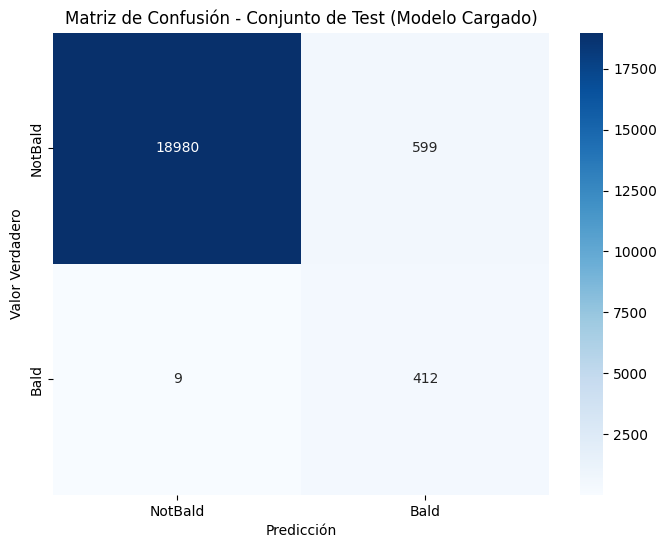

In [23]:
# --- 4. Calcular y Mostrar Matriz de Confusión ---
# Línea corregida (acceder al dataset original)

print("\nReporte de Clasificación:")
print(classification_report(all_labels_test, all_preds_test, target_names=original_test_dataset.class_names))

print("\nMatriz de Confusión:")
cm = confusion_matrix(all_labels_test, all_preds_test)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
             xticklabels=original_test_dataset.class_names, yticklabels=original_test_dataset.class_names)
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.title('Matriz de Confusión - Conjunto de Test (Modelo Cargado)')
plt.show()

## 6. Results and discussion

- Se entrenó una CNN (ResNet50 con Transfer Learning) para clasificar imágenes como 'Bald' o 'NotBald'.

- El desbalance extremo del dataset se manejó con undersampling en el entrenamiento.

- El modelo final alcanzó un 96.96% de precisión en el conjunto de test original y desbalanceado. Y un 98,65% sobre validación durante el entrenamiento 

- A pesar de estar desbalanceado vemos muy buen rendimiento en la matriz de confusión acertadno la mayoría de Calvos y No Calvos

In [24]:
# guardo los requirements en un .txt
!pip freeze > requirements.txt